## DSC 425 - Time Series Analysis
## Final Project Submission
#### ``Submitted By: Anuj Verma``

    This submission contains the work done by Anuj Verma as part of the final project DSC 425 titled 'LANL Earthquake Predictions using Seismic Data'. This is an ongoing Kaggle challange with grand prize of $50,000.

In [4]:
import pandas as pd
import numpy as np

#timeseries libraries
from statsmodels import tsa
from statsmodels.graphics import tsaplots
from statsmodels.api import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from scipy import stats
from pmdarima.arima import auto_arima

#machine-learning algorithms
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error

#viz
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

#others
from collections import defaultdict
from tqdm import tqdm 
import pickle as pkl
#ignore Future warnings
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

In [154]:
data = pd.read_csv('x_train_105.csv',index_col=[0])
target = pd.read_csv('y_train_105.csv',index_col=[0],squeeze=True)
print('X:',data.shape)
print('Y:',target.shape)

X: (10485, 3)
Y: (10485,)


In [155]:
data.head()

,average,std,seismic
0,4.92920,6.153572,NaN
1,5.02705,4.472317,0.09785
2,4.57750,6.324028,-0.44955
3,4.71020,6.750293,0.13270
4,4.78075,5.482789,0.07055


In [156]:
#compute return on average
rseismic = data['average'].diff()
rseismic.dropna(inplace=True)
rseismic.head()

1    0.09785
2   -0.44955
3    0.13270
4    0.07055
5   -0.04930
Name: average, dtype: float64

In [151]:
rseismic.shape

(10484,)

In [157]:
target.head()

0    1.454197
1    1.438299
2    1.423396
3    1.407397
4    1.391499
Name: time_to_failure, dtype: float64

In [158]:
#exclude the first entry of target as we deleted the first null value from return series
target = target[1:]

In [159]:
print(rseismic.shape)
print(target.shape)

(10484,)
(10484,)


In [57]:
#define a function to plot timeseries
def plot_timeseries(series, title=None,xlabel=None,ylabel=None):
    '''
     Plot the timeseries with a figure size 16,6.
     
    '''
    plt.figure(figsize=(16,6))
    plt.plot(series)
    if title!=None: plt.title(title)
    if xlabel!=None: plt.xlabel(xlabel)
    if ylabel!=None: plt.ylabel(ylabel)
    plt.show()

def plot_autocorrelation(series,nlags,plot=None):
    '''
     Plot auto-correlation functions ACF and PACF.
     Arguments:
         series: time-series object
         nlags: number of lags to show on correlation plots.
         plot: Accecpted values: ['ACF','PACF',None]
             If None then plot both ACF and PACF plots.
    '''
    from statsmodels.graphics import tsaplots
    
    fsize=(12,8)
    subplot=211
    
    if plot!=None: 
        fsize=(12,4)
        subplot=111
    
    fig= plt.figure(figsize=fsize)
    ax=fig.add_subplot(subplot)
    
    if plot==None or 'ACF':
        fig=tsaplots.plot_acf(series,lags=nlags,ax=ax)
        plt.xticks(range(nlags))
    
    if plot==None: 
        ax = fig.add_subplot(212)
    if plot==None or 'PACF':
        fig=tsaplots.plot_pacf(series,lags=nlags,ax=ax)
        plt.xticks(range(nlags))
    
    plt.xlabel('Lag-K')
    plt.show()


In [312]:
def test_ljungbox(series,nlags):
    '''
     Function to conduct ljungbox test.
    '''
    from statsmodels.stats.diagnostic import acorr_ljungbox
    
    s,p=acorr_ljungbox(series,lags=nlags)
    
    print('Ljung-Box test for {}-lags\n\n\tStatistics:\n{}\n\tp-values:\n{}'.format(nlags,s,p))

def test_dickeyFuller(series,reg_method='c',ic='BIC'):
    '''
     Conduct Augmented Dickey-Fuller test.
    '''
    from statsmodels.tsa.stattools import adfuller
    
    results=adfuller(series,regression=reg_method,autolag=ic)
    
    print('Augmented Dickey Fuller test results:')
    print('Test Statistics:',results[0])
    print('p-values:',results[1])
    print('Used lags:',results[2])
    print('Observations used:',results[3])
    print('Significance levels:\n\t{}'.format(results[4]))
    

In [47]:
def custom_train_test_split(X,y,train_size):
    '''
     Custom function to split the data into train-test
     train_size: [Float] between 0-1
     
     Returns:
         [Xtrain,Xtest,ytrain,ytest]
     
    '''
    
    length = X.shape[0]
    split_size = int(length*train_size)
    
    X_train,X_test = X[:split_size],X[split_size:]
    y_train,y_test = y[:split_size],y[split_size:]
    
    return X_train,X_test,y_train,y_test

In [162]:
X_train,X_test,y_train,y_test = custom_train_test_split(rseismic,target,train_size=0.95)

In [163]:
print("X_train : ",X_train.shape)
print("y_train : ",y_train.shape)
print("X_test : ",X_test.shape)
print("y_test : ",y_test.shape)

X_train :  (9959,)
y_train :  (9959,)
X_test :  (525,)
y_test :  (525,)


In [164]:
auto_arima(X_train,d=1,information_criterion='aic',stepwise=True,trace=True,suppress_warnings=True)

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-9252.973, BIC=-9209.736, Fit time=11.639 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=1086.056, BIC=1100.468, Fit time=1.776 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-2929.511, BIC=-2907.893, Fit time=0.806 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-8346.672, BIC=-8325.054, Fit time=6.343 seconds


C:\Users\gurprkau\AppData\Local\Continuum\anaconda3\lib\site-packages\pmdarima\arima\auto.py:870: ModelFitWarning: Unable to fit ARIMA for order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-9602.545, BIC=-9552.102, Fit time=15.794 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-9815.842, BIC=-9772.606, Fit time=14.875 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-4859.830, BIC=-4831.006, Fit time=0.985 seconds
Fit ARIMA: order=(4, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-9746.955, BIC=-9689.306, Fit time=19.771 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-9587.252, BIC=-9551.221, Fit time=11.063 seconds
Fit ARIMA: order=(4, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-9823.226, BIC=-9772.783, Fit time=14.098 seconds
Fit ARIMA: order=(4, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-6720.397, BIC=-6677.161, Fit time=1.497 seconds
Fit ARIMA: order=(3, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-5946.761, BIC=-5910.731, Fit time=1.177 seconds


C:\Users\gurprkau\AppData\Local\Continuum\anaconda3\lib\site-packages\pmdarima\arima\auto.py:870: ModelFitWarning: Unable to fit ARIMA for order=(5, 1, 2) seasonal_order=(0, 0, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(5, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(5, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-9758.488, BIC=-9700.839, Fit time=16.935 seconds
Total fit time: 116.841 seconds


ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(4, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

### Train ARIMA model on data['average']

In [187]:

def backtest_Arima(X,arima_order,test_size):
    '''
     Backtest ARIMA model
    '''
    X = X.values
    results_dict = defaultdict(list)
    length = X.shape[0]
    train_len = int((1-test_size)*length)
    exception_at = []
    
    for idx in tqdm(range(length-train_len)):
        #create train and test set with sliding window = length of train set
        train,test=X[idx:train_len+idx],X[train_len+idx]
        
        #fit ARIMA model on train and forecast next point
        try:
            model = SARIMAX(train,order=arima_order,enforce_stationarity=False,enforce_invertibility=False)
            model_fit = model.fit()
        except np.linalg.LinAlgError as e:
            exception_at.append(idx)
            continue

        #forecast next value of series
        predictions = model_fit.get_forecast(steps=1)
        pred = predictions.predicted_mean.flatten()
        pred_ci = predictions.conf_int(alpha=0.05)
        
        results_dict['actual'].append(test)
        results_dict['prediction'].append(pred[0])
        results_dict['lower_ci'].append(pred_ci[:,0][0])
        results_dict['upper_ci'].append(pred_ci[:,1][0])
        
        err = np.abs(test-pred)
        results_dict['abs_err'].append(err)
        
    if len(exception_at)>0:
        print('LinAlgError exception: SVD unable to converge; encountered at below iterations:\n{}'.format(exception_at))

    return results_dict,model_fit

In [169]:
def save_results(obj, filename):
    '''
     Function to save the results in a pickle object
    '''
    import pickle as pkl
    
    try:
        with open(filename+'.pkl','wb') as file:
            pkl.dump(obj,file)
    except Exception  as e:
        print('An error occurred while saving the file. Please review below msg for further information..\n',e)
        return
    print('File saved successfully as {}.pkl'.format(filename))
    
def load_results(filename):
    '''
     Function to load the results saved in a pickle object
    '''
    import pickle as pkl
    
    try: 
        with open(filename+'.pkl','rb') as file:
            f = pkl.load(file)
    except FileNotFoundError as fe:
        print('Could not find file {}.pkl in the system.'.format(filename))
        return
    except Exception as e:
        print('An error occurred while loading the file. Please review the below message..\n',e)
        return
    
    return f
    

In [170]:
#test performance on ARIMA(1,1,1) model as this is reported as best by other team member
result,model111 = backtest_Arima(data['average'],arima_order = (1,1,1),test_size=0.05)

 10%|█         | 54/525 [00:59<09:10,  1.17s/it]C:\Users\gurprkau\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 18%|█▊        | 94/525 [01:46<08:55,  1.24s/it]C:\Users\gurprkau\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 30%|███       | 160/525 [03:05<07:32,  1.24s/it]C:\Users\gurprkau\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 44%|████▍     | 231/525 [04:33<07:46,  1.59s/it]C:\Users\gurprkau\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: Con

In [171]:
print('Mean absolute error for ARIMA(1,1,1) backtesting: ',np.mean(result['abs_err']))

Mean absolute error for ARIMA(1,1,1) backtesting:  0.12148723121682795


In [173]:
results411,model411 = backtest_Arima(data['average'],arima_order=(4,1,1),test_size=0.05)

 33%|███▎      | 173/525 [08:08<20:59,  3.58s/it]C:\Users\gurprkau\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 74%|███████▍  | 388/525 [18:49<07:23,  3.24s/it]C:\Users\gurprkau\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 75%|███████▌  | 395/525 [19:11<06:21,  2.93s/it]C:\Users\gurprkau\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 92%|█████████▏| 483/525 [23:25<01:46,  2.53s/it]C:\Users\gurprkau\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: C

In [174]:
print('Mean Absolute Error for ARIMA(4,1,1) backtesting: ',np.mean(results411['abs_err']))

Mean Absolute Error for ARIMA(4,1,1) backtesting:  0.12137063977714511


In [ ]:
results212,model212 = backtest_Arima(data['average'],arima_order = (2,1,2),test_size=0.05)

In [ ]:
print('Mean Absolute Error for ARIMA(2,1,2) backtesting: ',np.mean(results212['abs_err']))

In [189]:
#save the results
pd.DataFrame(result).to_csv('ARIMA111_backtest_results.csv')
pd.DataFrame(results411).to_csv('ARIMA411_backtest_results.csv')
#pd.DataFrame(results212).to_csv('ARIMA212_backtest_results.csv')

In [190]:
pd.DataFrame(results411).head(10)

,actual,prediction,lower_ci,upper_ci,abs_err
0,3.942717,3.977507,3.696995,4.258019,[0.034790271169600206]
1,4.087033,3.957359,3.676855,4.237863,[0.12967429492379923]
2,4.123433,4.032702,3.752290,4.313114,[0.09073152208717072]
3,4.296783,4.062232,3.781823,4.342641,[0.23455124645090475]
4,4.044150,4.169324,3.888886,4.449763,[0.12517445835013064]
5,4.276433,4.053881,3.773440,4.334322,[0.2225524352286099]
6,4.362783,4.173724,3.893255,4.454193,[0.18905948833183395]
7,4.404317,4.236572,3.956077,4.517068,[0.16774445815711658]
8,4.407283,4.273845,3.993363,4.554328,[0.13343787941228147]
9,4.358683,4.296351,4.015859,4.576843,[0.06233250767541332]


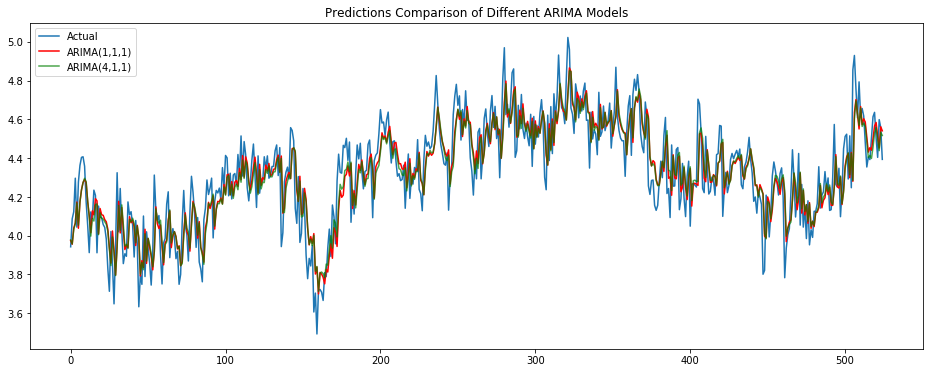

In [194]:
plt.figure(figsize=(16,6))
plt.plot(result['actual'],'',label='Actual')
plt.plot(result['prediction'],'r',label='ARIMA(1,1,1)')
plt.plot(results411['prediction'],c='g',label='ARIMA(4,1,1)',alpha=0.7)
#plt.plot(results414['prediction'],c='g',label='ARIMA(4,1,4)')
plt.title('Predictions Comparison of Different ARIMA Models')
plt.legend()
plt.show()

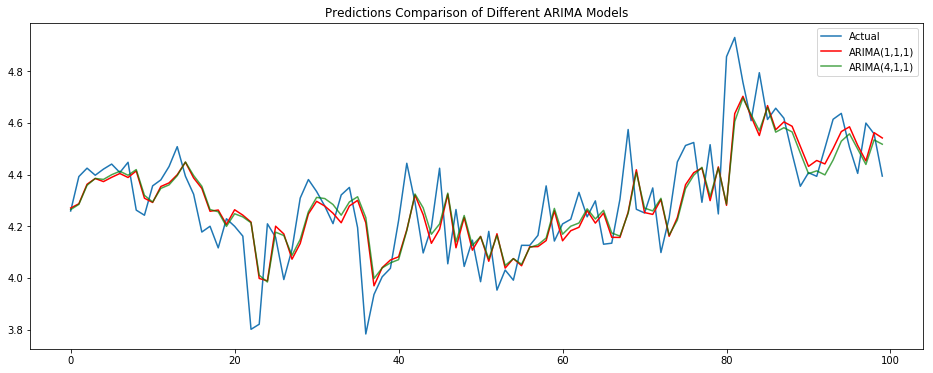

In [195]:
plt.figure(figsize=(16,6))
plt.plot(result['actual'][-100:],'',label='Actual')
plt.plot(result['prediction'][-100:],'r',label='ARIMA(1,1,1)')
plt.plot(results411['prediction'][-100:],c='g',label='ARIMA(4,1,1)',alpha=0.7)
#plt.plot(results414['prediction'],c='g',label='ARIMA(4,1,4)')
plt.title('Predictions Comparison of Different ARIMA Models')
plt.legend()
plt.show()

#### Train Linear Regression Model on train_set

In [196]:
X_train2,X_test2,y_train2,y_test2 = custom_train_test_split(X_train,y_train,train_size=0.9)

In [197]:
#train regression model 

lr = LinearRegression()
m1 = lr.fit(pd.DataFrame(X_train2),pd.DataFrame(y_train2))

In [198]:
pred = m1.predict(pd.DataFrame(X_test2))

In [200]:
mean_absolute_error(y_test2,pred)

2.949372696280637

In [201]:
pred_validation = m1.predict(pd.DataFrame(X_test))

In [203]:
#MAE for validation data
lr_mae_val = mean_absolute_error(y_test,pred_validation)
print('Linear Regression MAE for Validation Set X_test: ',lr_mae_val)

Linear Regression MAE for Validation Set X_test:  3.1149714373124078


In [205]:
#save model 
save_results(m1,'lr_model')

File saved successfully as lr_model.pkl


In [206]:
lr_pred = pd.DataFrame(data={'actual':y_test.values,'predictions':pred_validation.flatten()})

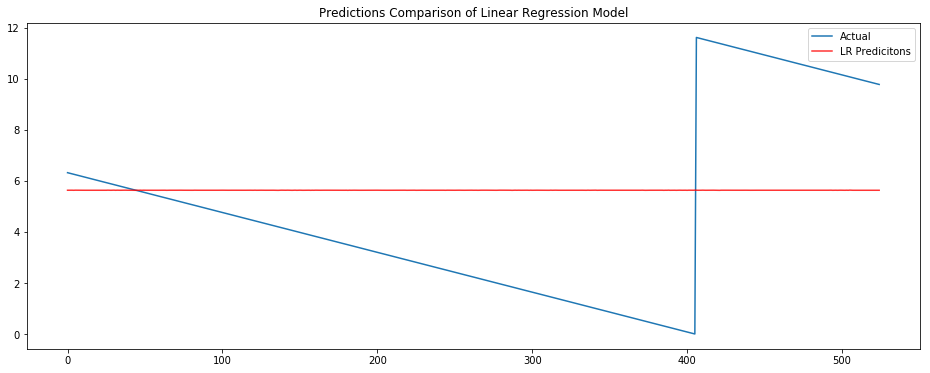

In [207]:
plt.figure(figsize=(16,6))
plt.plot(lr_pred['actual'],'',label='Actual')
plt.plot(lr_pred['predictions'],'r',label='LR Predicitons',alpha=0.8)
plt.title('Predictions Comparison of Linear Regression Model')
plt.legend()
plt.show()

**LR Residual Analysis**

In [251]:
lr_res = y_test.values-pred_validation.flatten()

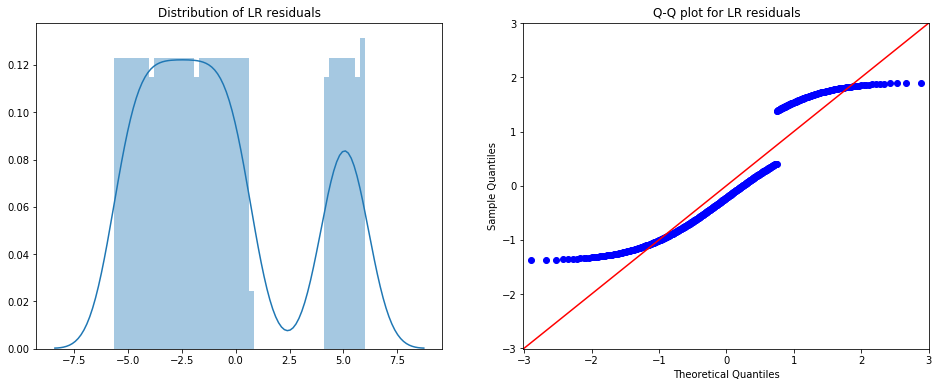

mean: -0.7625412667953204, skewness:0.646, kurtosis: -0.847


In [254]:
#plot histogram and QQplot
fig=plt.figure(figsize=(16,6))
ax1=plt.subplot(121)
fig=sns.distplot(lr_res,bins=50,ax=ax1)
plt.title('Distribution of LR residuals')
ax2=plt.subplot(122)
fig= qqplot(lr_res,fit=True,line='45',ax=ax2)
plt.title('Q-Q plot for LR residuals')
plt.show()
print('mean: {}, skewness:{:.3f}, kurtosis: {:.3f}'.\
      format(np.mean(lr_res),stats.skew(lr_res),stats.kurtosis(lr_res)))

In [271]:
test_ljungbox(lr_res,10)

Ljung-Box test for 10-lags

	Statistics:
[ 515.21218412 1018.78272855 1510.85016099 1991.55741259 2461.04246421
 2919.44897624 3366.9133104  3803.57199685 4229.56850619 4645.04327002]
	p-values:
[4.65804652e-114 5.94485636e-222 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000]


The above results comparison graph for Linear regression predictions shows that our model is unable to predict the time_to_failure by a large margin. This might be because linear model is not suitable for this problem. As can be seen from the graph. Let us now, try with some advanced non-linear models.


#### SVM model performance 

In [208]:
from sklearn.svm import SVR

The below parameters for svm have been used after trying different range of parameters for C varying from 1-3000000. The high range of C is due to very small difference between the consecutive time_to_failure values. Also, SVM with polynomial kernel with degree 2 was tried but the below gave the best results.

In [209]:
svr = SVR(kernel='rbf',C=3000000)
svr_fit = svr.fit(pd.DataFrame(X_train2),y_train2)
svr_fit

SVR(C=3000000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [211]:
svr_pred = svr_fit.predict(pd.DataFrame(X_test2))

In [212]:
svr_mae = mean_absolute_error(y_test2,svr_pred)
print('MAE of Gaussian Kernel SVM for X_test2: ',svr_mae)

MAE of Gaussian Kernel SVM for X_test2:  2.9902980559134433


In [219]:
save_results(svr_fit,'svm_model')

File saved successfully as svm_model.pkl


In [213]:
svr_validation = svr_fit.predict(pd.DataFrame(X_test))
svr_mae_val = mean_absolute_error(y_test,svr_validation)
print('MAE of Gaussian Kernel SVM for Validation Set X_test: ',svr_mae_val)

MAE of Gaussian Kernel SVM for Validation Set X_test:  3.0889313948089083


In [214]:
svm_pred_df = pd.DataFrame(data={'actual':y_test.values,'predictions':svr_validation.flatten()})

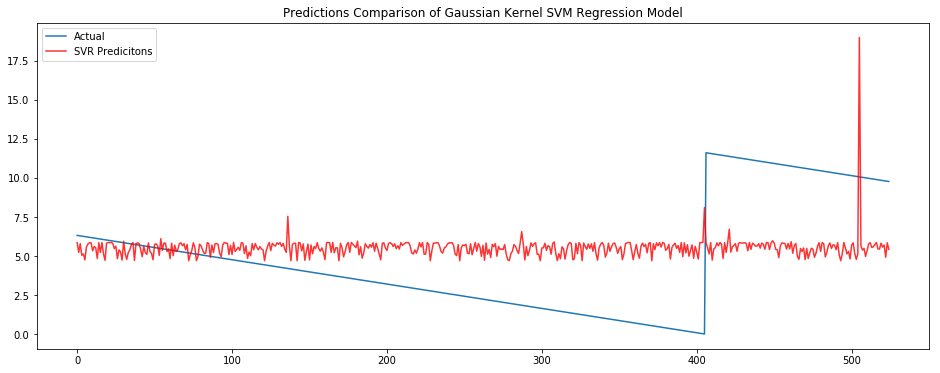

In [215]:

plt.figure(figsize=(16,6))
plt.plot(svm_pred_df['actual'],'',label='Actual')
plt.plot(svm_pred_df['predictions'],'r',label='SVR Predicitons',alpha=0.8)
plt.title('Predictions Comparison of Gaussian Kernel SVM Regression Model')
plt.legend()
plt.show()

**SVM Residual Analysis**

In [267]:
svr_res = svm_pred_df.actual-svm_pred_df.predictions

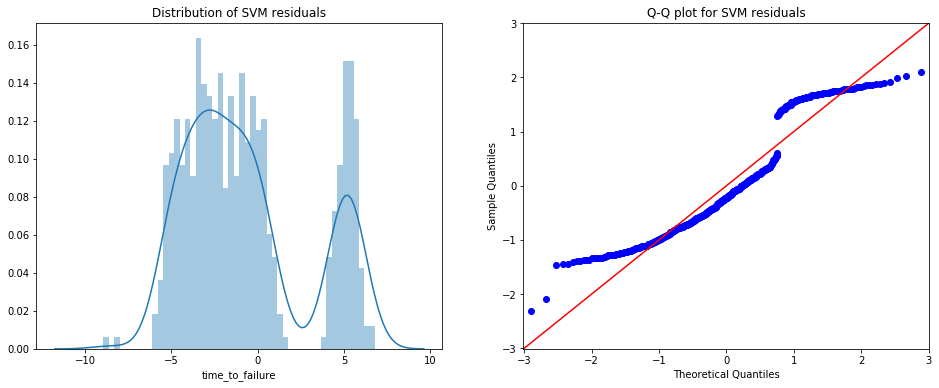

mean: -0.6531753606715754, skewness:0.598, kurtosis: -0.806


In [257]:
#plot histogram and QQplot
fig=plt.figure(figsize=(16,6))
ax1=plt.subplot(121)
fig=sns.distplot(svr_res,bins=50,ax=ax1)
plt.title('Distribution of SVM residuals')
ax2=plt.subplot(122)
fig= qqplot(svr_res,fit=True,line='45',ax=ax2)
plt.title('Q-Q plot for SVM residuals')
plt.show()
print('mean: {}, skewness:{:.3f}, kurtosis: {:.3f}'.\
      format(np.mean(svr_res),stats.skew(svr_res),stats.kurtosis(svr_res)))

#### RandomForest Regressor performance 

In [216]:
from sklearn.ensemble import RandomForestRegressor

Different number of decision tree estimators were used during construction of RandomForest regressor. However, n_estimators=50 gave the optimal results among all other tried.

In [237]:
rf = RandomForestRegressor(n_estimators=50,criterion='mae',random_state=10)
rf_fit = rf.fit(pd.DataFrame(X_train2),y_train2)
rf_fit

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
           oob_score=False, random_state=10, verbose=0, warm_start=False)

In [238]:
rf_pred = rf_fit.predict(pd.DataFrame(X_test2))
rf_mae = mean_absolute_error(y_test2,rf_pred)
print('MAE of Random Forest for X_test2: ',rf_mae)

MAE of Random Forest for X_test2:  3.3656880269701603


In [239]:
rf_validation = rf_fit.predict(pd.DataFrame(X_test))
rf_mae_val = mean_absolute_error(y_test,rf_validation)
print('MAE of Random Forest for Validation Set X_test: ',rf_mae_val)

MAE of Random Forest for Validation Set X_test:  3.561031324229823


In [221]:
save_results(rf_fit,'random_forest_model')

File saved successfully as random_forest_model.pkl


In [240]:
rf_pred_df = pd.DataFrame(data={'actual':y_test.values,'predictions':rf_validation.flatten()})

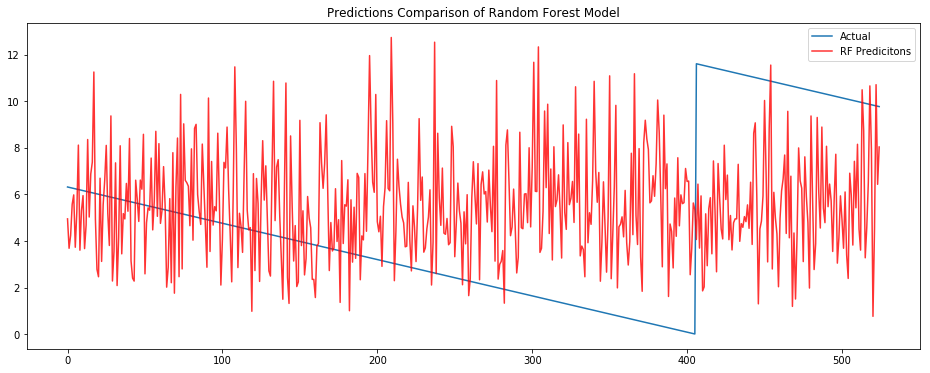

In [241]:
plt.figure(figsize=(16,6))
plt.plot(rf_pred_df['actual'],'',label='Actual')
plt.plot(rf_pred_df['predictions'],'r',label='RF Predicitons',alpha=0.8)
plt.title('Predictions Comparison of Random Forest Model')
plt.legend()
plt.show()

**RF Residual Analysis**

In [265]:
rf_res = rf_pred_df.actual-rf_pred_df.predictions

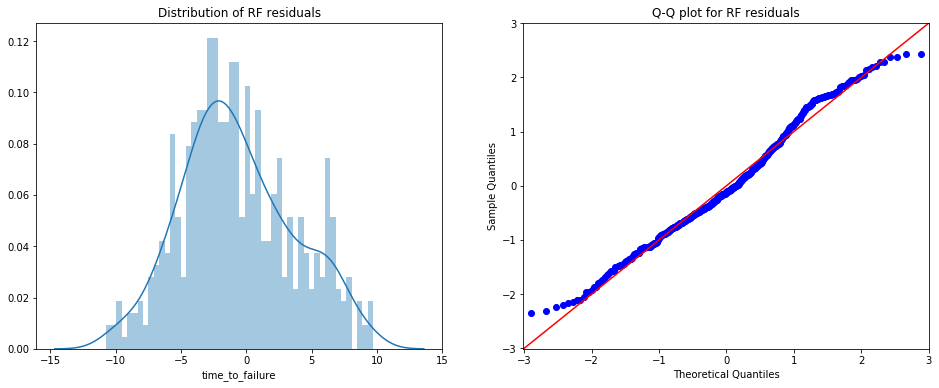

mean: -0.6776462821592509, skewness:0.259, kurtosis: -0.428


In [259]:
#plot histogram and QQplot
fig=plt.figure(figsize=(16,6))
ax1=plt.subplot(121)
fig=sns.distplot(rf_res,bins=50,ax=ax1)
plt.title('Distribution of RF residuals')
ax2=plt.subplot(122)
fig= qqplot(rf_res,fit=True,line='45',ax=ax2)
plt.title('Q-Q plot for RF residuals')
plt.show()
print('mean: {}, skewness:{:.3f}, kurtosis: {:.3f}'.\
      format(np.mean(rf_res),stats.skew(rf_res),stats.kurtosis(rf_res)))

In [270]:
test_ljungbox(rf_res,10)

Ljung-Box test for 10-lags

	Statistics:
[ 262.46932139  506.46765298  768.38616792 1028.05665985 1261.23802791
 1489.85676092 1720.62448229 1940.51280289 2156.41360087 2366.41140057]
	p-values:
[4.96904165e-059 1.05183235e-110 3.10711685e-166 2.96595044e-221
 1.59473695e-270 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000]


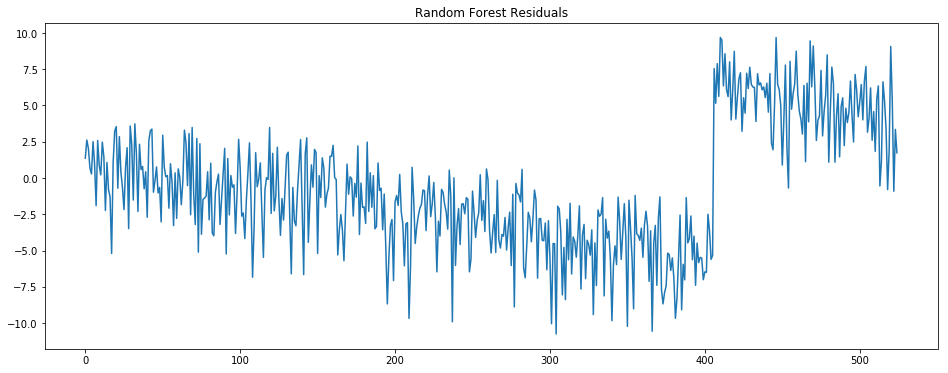

In [266]:
plot_timeseries(rf_res,'Random Forest Residuals')

The residual plot for Random Forest shows some new directions that we can take with this dataset. We can see the residuals are close to a normal distribution as can be seen from histogram and qqplots. Also, the residual plot shows the timeseries behaviour which should be investigated. We can also see the intevention after 400th observation. It will be interesting to use random-forest with time-series models and see the results we get.

However, for this project, I will not explore this further and leave it as a future direction.

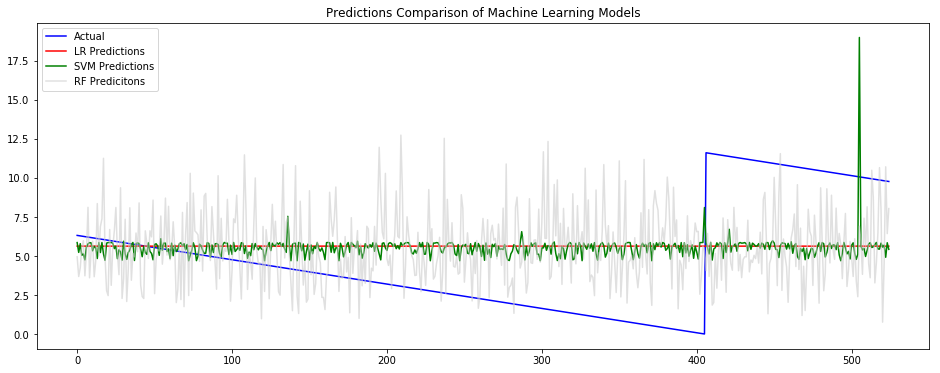

In [292]:
#plot predictions from all the algorithms on one plot
plt.figure(figsize=(16,6))
plt.plot(lr_pred['actual'],'b',label='Actual')
plt.plot(lr_pred['predictions'],'r',label = 'LR Predictions')
plt.plot(svm_pred_df['predictions'],'g',label='SVM Predictions')
plt.plot(rf_pred_df['predictions'],c='0.8',label='RF Predicitons',alpha=0.6)
plt.title('Predictions Comparison of Machine Learning Models')
plt.legend()
plt.show()

**Conclusion**: All of the above machine learning models are not doing good enough to predict our target variable i.e. time_to_failure. This might be because we just have one feature (average_seismic_data) to train the model with Or it could also be because we are not feeding enough data to our model. In future, I should try these two approaches as well to improve my results. 

For now, we have settled with the time-series regression model that one of my teammate created, which is the best model we got so-far.

## Try Timeseries-SVM model check the performance
    This method extends the principles of timeseries linear regression to implement the SVM model instead of linear regression model. The timeseries is generated from the residuals of SVM model assuming time_to_failure as a target variable and seismic_data as independent variable.
    
    Note: This method does not require splitting the data two times as was done in above methodologies. 

**Overall Strategy will be as given below:**
1. Split the data into 95% training and 5% testing.
2. Train an SVM model using training data and calculate the residuals.
3. Analyse the residuals and perform necessary transformations.
4. Perform the timeseries analysis on residuals.
5. Fit an appropriate timeseries model assuming time_to_failure as target variable and seismic as independent variable. 

In [293]:
#1. Split the data
df = pd.DataFrame(data={'average':data['average'].values[1:],'time_to_failure':target.values})

In [294]:
df.head()

,average,time_to_failure
0,5.02705,1.438299
1,4.57750,1.423396
2,4.71020,1.407397
3,4.78075,1.391499
4,4.73145,1.376596


C:\Users\gurprkau\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


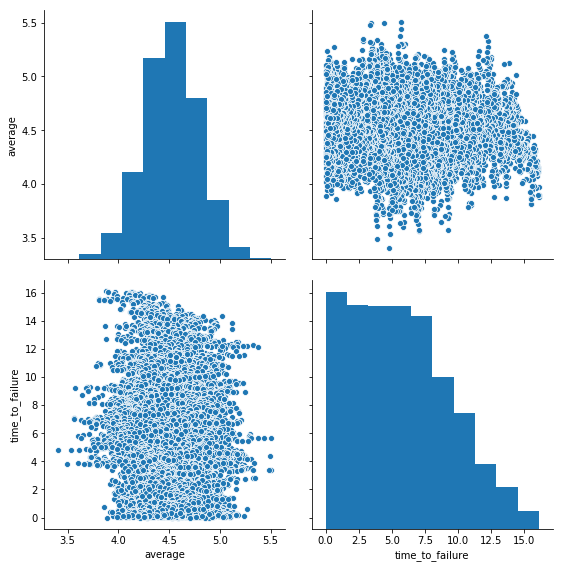

In [295]:
#find correlation between the two features
fig = sns.pairplot(df,size=4)

**there does not seem any strong linear relationship within the two features. But again, this was known to me since my project partner already performed this test. That is the reason I am using the non-linear technique SVM for this data**

In [296]:
#Now let us divide the data into 95-5 splits
Xtrain,Xtest,ytrain,ytest = custom_train_test_split(df['average'],df['time_to_failure'],train_size=0.95)

print('Xtrain shape:',Xtrain.shape)
print('ytrain shape:',ytrain.shape)
print('Xtest shape:',Xtest.shape)
print('ytest shape:',ytest.shape)

Xtrain shape: (9959,)
ytrain shape: (9959,)
Xtest shape: (525,)
ytest shape: (525,)


In [302]:
svr = SVR(kernel='rbf',C=10000000)
svr_fit = svr.fit(pd.DataFrame(Xtrain),ytrain)


In [303]:
ytrain_hat = svr_fit.predict(pd.DataFrame(Xtrain))

mae_train = mean_absolute_error(ytrain,ytrain_hat)
print('MAE for train prediction error:',mae_train)

MAE for train prediction error: 3.084995245350403


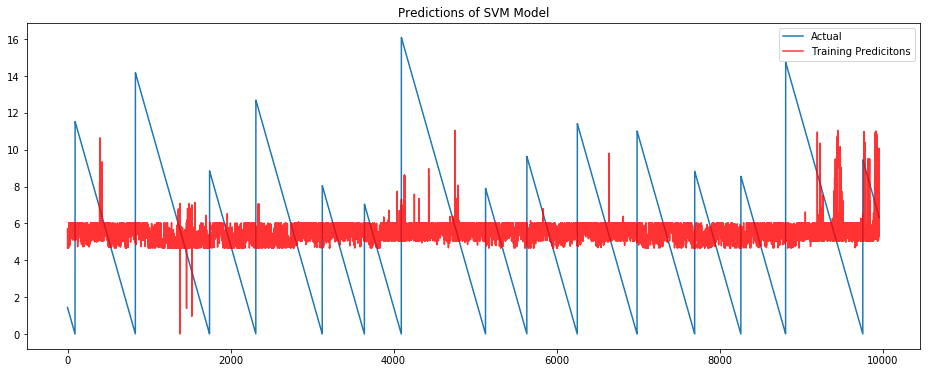

In [304]:
plt.figure(figsize=(16,6))
plt.plot(ytrain,'',label='Actual')
plt.plot(ytrain_hat,'r',label='Training Predicitons',alpha=0.8)
plt.title('Predictions of SVM Model')
plt.legend()
plt.show()

In [305]:
svr2_res = ytrain-ytrain_hat 

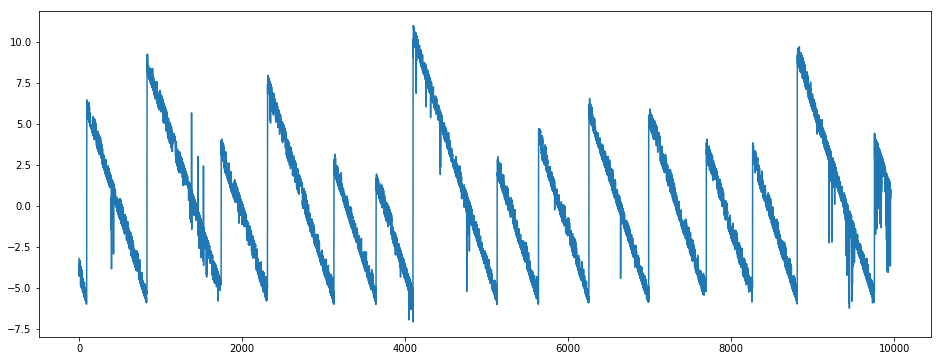

In [306]:
plot_timeseries(svr2_res)

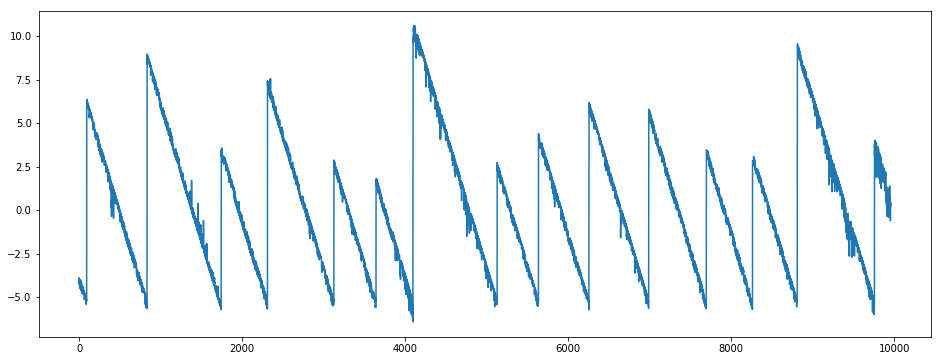

In [301]:
plot_timeseries(svr2_res)

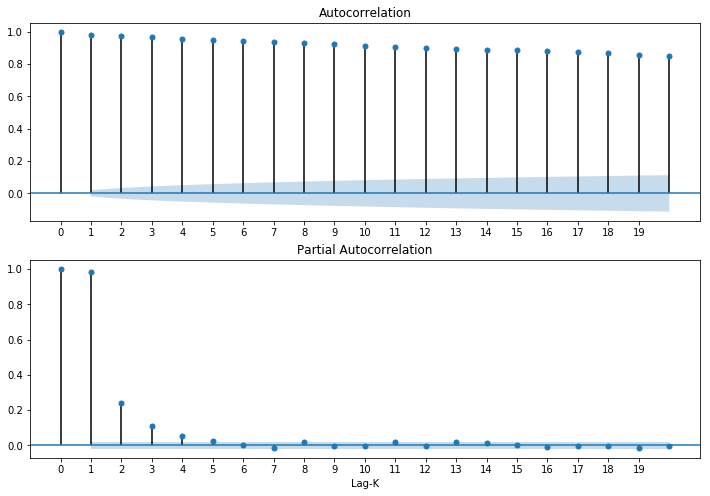

In [307]:
plot_autocorrelation(svr2_res,20)

In [316]:
test_dickeyFuller(svr2_res,reg_method='ct',ic='AIC')

Augmented Dickey Fuller test results:
Test Statistics: -6.080580928672127
p-values: 1.4851129136483875e-06
Used lags: 7
Observations used: 9951
Significance levels:
	{'1%': -3.959680055085228, '5%': -3.4109312931873843, '10%': -3.127309872842803}


In [315]:
adfuller(svr2_res,regression='ctt')

(-6.11946607696437,
 7.205880811467084e-06,
 7,
 9951,
 {'1%': -4.372294888243512,
  '5%': -3.8329836042955234,
  '10%': -3.5536278155510206},
 20365.091815521882)

In [ ]:
The Augmented dickey fuller test gives us significant p-values for 3 lags. 

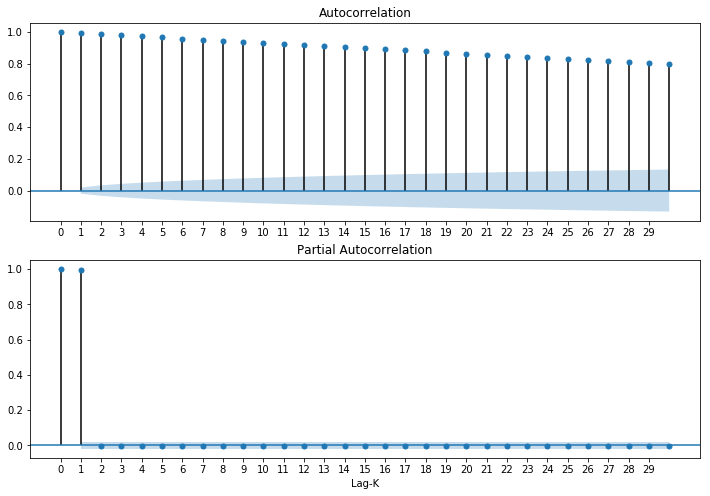

In [62]:
plot_autocorrelation(df.time_to_failure,30)

The ACF and PACF plots for time_to_failure show the non-stationary behaviour of time_to_failure. Let us confirm this with Augmented dickey fuller test.

In [66]:
test_dickeyFuller(df.time_to_failure,reg_method='c')

Augmented Dickey Fuller test results:
Test Statistics: -3.106191013622721
p-values: 0.0018843006931617695
Used lags: 0
Significance levels:
	{'1%': -2.5659533116463553, '5%': -1.9410256530298367, '10%': -1.6167946884159636}


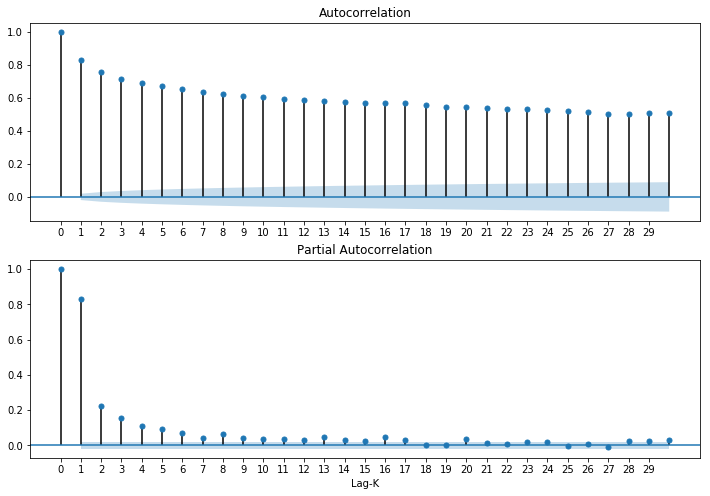

In [68]:
plot_autocorrelation(df.average,nlags=30)

The ACF and PACF plots for averaged seismic data also shows the non-stationary behaviour along with some seasonality. Let us work  on the stationarize and de-seasonalize the dataset.

In [318]:
#calculate returns of on dataset
df['raverage'] = df.average.diff()
df['rtime_to_failure']=df.time_to_failure.diff()
df.dropna(inplace=True)

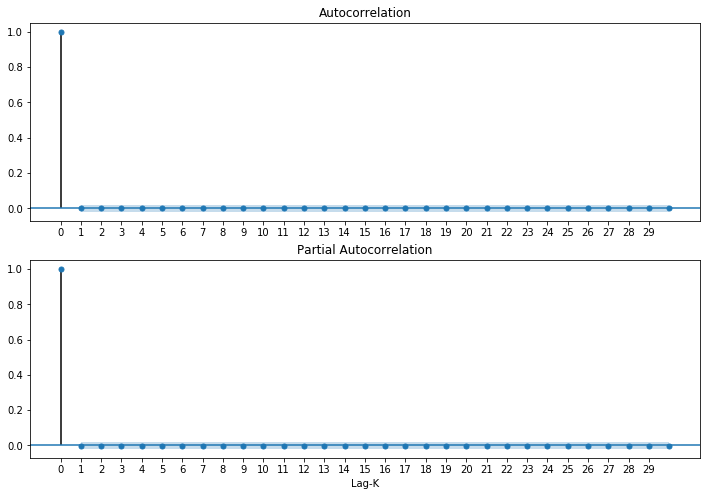

In [319]:
plot_autocorrelation(df.rtime_to_failure,30)

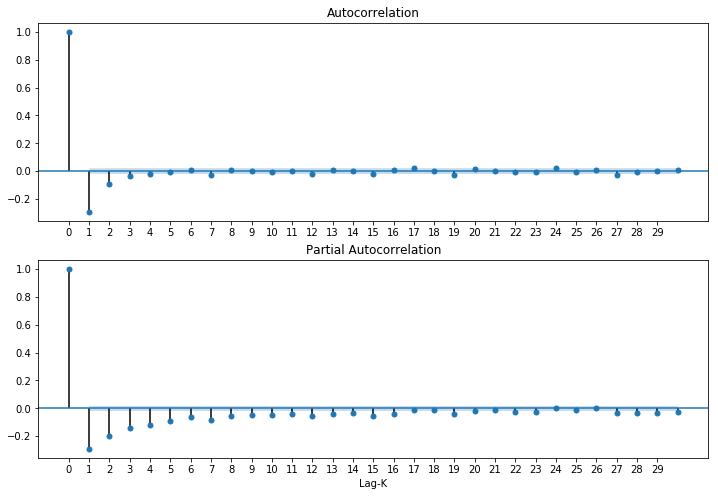

In [320]:
#see if the series is stationary
plot_autocorrelation(df.raverage,30)

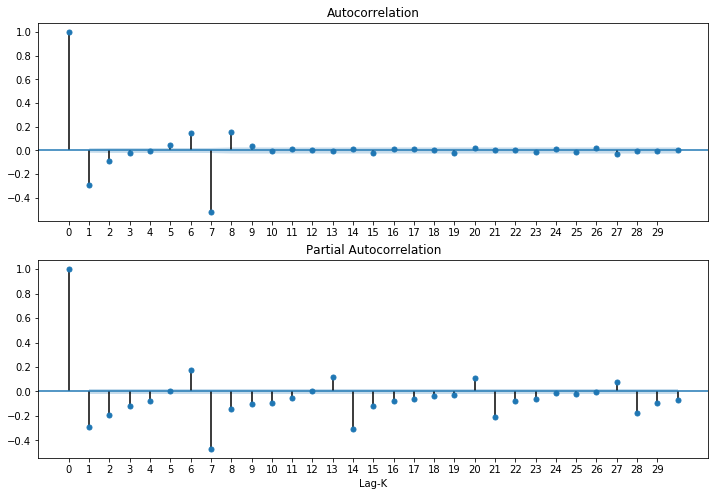

In [80]:
plot_autocorrelation(df.raverage.diff(7).dropna(),30)

Although the data seems to be seasonal, the seasonality is really less in the data. The de-seasonlizing the data does not help as it introduces additional inverted correlation. So, I am going to proceed with the model considering the dataset as non-seasonal.

In [321]:
#Now let us divide the data into 95-5 splits
Xrtrain,Xrtest,yrtrain,yrtest = custom_train_test_split(df['raverage'],df['rtime_to_failure'],train_size=0.95)

print('Xtrain shape:',Xrtrain.shape)
print('ytrain shape:',yrtrain.shape)
print('Xtest shape:',Xrtest.shape)
print('ytest shape:',yrtest.shape)

Xtrain shape: (9958,)
ytrain shape: (9958,)
Xtest shape: (525,)
ytest shape: (525,)


In [326]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
average,10483.0,4.519377,0.271558,3.406933,4.340567,4.522117,4.703067,5.507733
time_to_failure,10483.0,5.680018,3.672816,0.002597,2.628797,5.351399,8.174197,16.094698
raverage,10483.0,-0.000060,0.159252,-0.607650,-0.107150,0.001900,0.107433,0.633583
rtime_to_failure,10483.0,0.000795,0.430899,-0.015999,-0.015998,-0.015898,-0.014903,16.092101


In [328]:
svr = SVR(kernel='rbf',C=1)
svr2_fit = svr.fit(pd.DataFrame(Xrtrain),yrtrain)


In [115]:
yrtrain_hat = svr2_fit.predict(pd.DataFrame(Xrtrain))

mae_train = mean_absolute_error(yrtrain,yrtrain_hat)
print('MAE for train prediction error:',mae_train)

MAE for train prediction error: 2.5667395866023575


In [117]:
pred = svr_fit.predict(pd.DataFrame(Xtest))
mae_test = mean_absolute_error(ytest,pred)
print('MAE for test prediction error:',mae_test)

MAE for test prediction error: 3.253413576642782


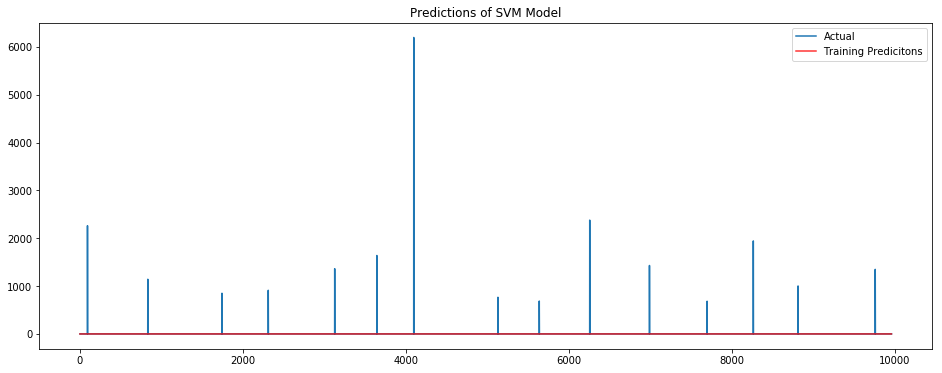

In [102]:
plt.figure(figsize=(16,6))
plt.plot(ytrain,'',label='Actual')
plt.plot(ytrain_hat,'r',label='Training Predicitons',alpha=0.8)
plt.title('Predictions of SVM Model')
plt.legend()
plt.show()

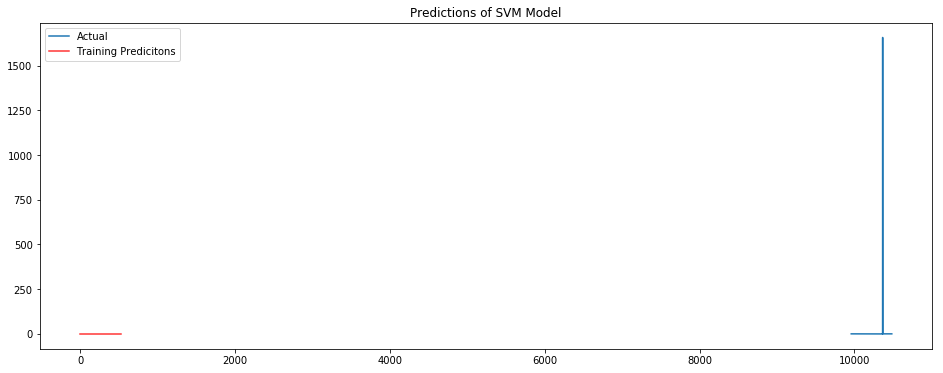

In [118]:
plt.figure(figsize=(16,6))
plt.plot(ytest,'',label='Actual')
plt.plot(pred,'r',label='Test Predicitons',alpha=0.8)
plt.title('Predictions of SVM Model')
plt.legend()
plt.show()

In [98]:
residuals = ytrain - ytrain_hat

In [113]:
#residual Analysis
len(svr_fit.support_vectors_)

118

In [132]:
svm = SVR(kernel='rbf',C=0.01)
svm_fit = svr.fit(pd.DataFrame(df.raverage),df.rtime_to_failure)


In [133]:
yhat = svm_fit.predict(pd.DataFrame(df.raverage))

mae = mean_absolute_error(df.rtime_to_failure,yhat)
print('MAE for train prediction error:',mae)

MAE for train prediction error: 2.6011197025331234


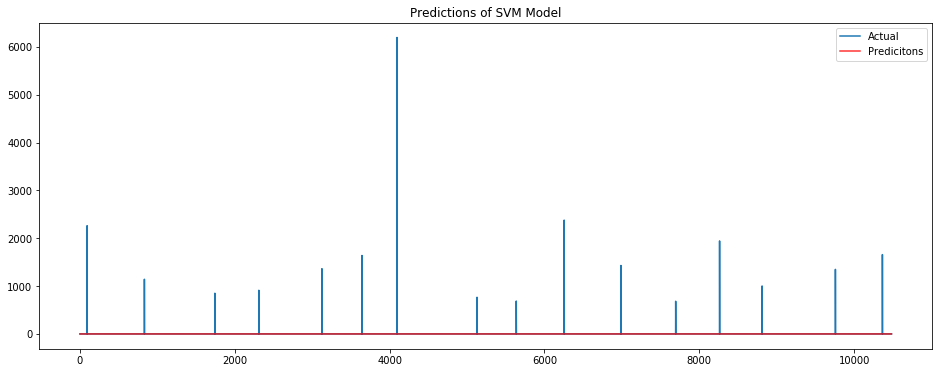

In [134]:
plt.figure(figsize=(16,6))
plt.plot(df.rtime_to_failure,'',label='Actual')
plt.plot(yhat,'r',label='Predicitons',alpha=0.8)
plt.title('Predictions of SVM Model')
plt.legend()
plt.show()

In [138]:
residuals = df.rtime_to_failure - yhat

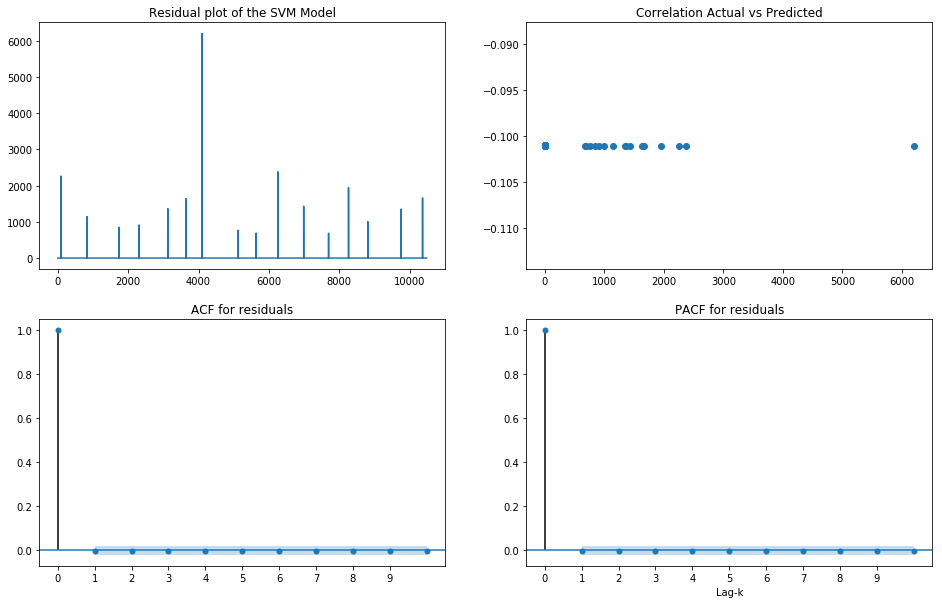

In [140]:
nlags = 10
fig = plt.figure(figsize=(16,10))
ax1 = plt.subplot(2, 2, 1)
ax1.plot(residuals)
plt.title("Residual plot of the SVM Model")
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(df.rtime_to_failure.values, yhat)
plt.title("Correlation Actual vs Predicted")
ax3 = plt.subplot(2, 2, 3)
fig = tsaplots.plot_acf(residuals, lags=nlags, ax=ax3,title='ACF for residuals')
plt.xticks(list(range(0,nlags)))
ax4 = plt.subplot(2, 2, 4)
fig = tsaplots.plot_pacf(residuals, lags=nlags, ax=ax4,title='PACF for residuals')
plt.xticks(list(range(0,nlags)))
plt.xlabel('Lag-k')
plt.show()

The above plots show no remaining auto-correlation between the lags.

In [143]:
auto_model = auto_arima(df.rtime_to_failure,exog=df.raverage,trace=True,stepwise=True,\
                        start_p=0,start_q=0,information_criterion='aic',error_action='ignore')
auto_model

Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=121987.530, BIC=122002.045, Fit time=0.281 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=121989.515, BIC=122011.287, Fit time=0.338 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=121989.515, BIC=122011.288, Fit time=0.419 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 1.058 seconds


ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 0, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend=None,
   with_intercept=True)

In [146]:
#model summary
arima_fit = auto_model.fit(pd.DataFrame(df.rtime_to_failure),exogenous=pd.DataFrame(df.raverage))
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10483
Model:                        SARIMAX   Log Likelihood              -60991.714
Date:                Mon, 18 Mar 2019   AIC                         121989.427
Time:                        00:55:40   BIC                         122011.200
Sample:                             0   HQIC                        121996.780
                              - 10483                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.4997      1.691      1.478      0.139      -0.815       5.815
x1            -6.0718     41.915     -0.145      0.885     -88.223      76.079
sigma2      6623.8492      4.697   1410.181      0.000    6614.643    6633.055
===================================================================================
Ljung-Box (Q):                        0.41   Jarque-Bera (JB):        5111955947.28
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            51.60
Prob(H) (two-sided):                  0.97   Kurtosis:                      3422.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**analyse performance with log-returns**

In [147]:
df['ln_avg']=np.log(df.average).diff()
df['ln_time_to_failure']=np.log(df.time_to_failure).diff()

In [149]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
average,10483.0,4.519377,0.271558,3.406933,4.340567,4.522117,4.703067,5.507733
time_to_failure,10483.0,5.680018,3.672816,0.002597,2.628797,5.351399,8.174197,16.094698
raverage,10483.0,0.000615,0.035465,-0.131431,-0.023426,0.000424,0.024120,0.143255
rtime_to_failure,10483.0,2.495967,81.391315,-0.851598,-0.005887,-0.002902,-0.001900,6196.359898
ln_avg,10482.0,-0.000004,0.035439,-0.140908,-0.023698,0.000424,0.023838,0.133879
ln_time_to_failure,10482.0,0.000184,0.288449,-1.907831,-0.005904,-0.002906,-0.001902,8.731879


In [148]:
df[['ln_avg','ln_time_to_failure']].describe()

,ln_avg,ln_time_to_failure
count,10482.000000,10482.000000
mean,-0.000004,0.000184
std,0.035439,0.288449
min,-0.140908,-1.907831
25%,-0.023698,-0.005904
50%,0.000424,-0.002906
75%,0.023838,-0.001902
max,0.133879,8.731879


In [132]:
svm = SVR(kernel='rbf',C=0.01)
svm_fit = svr.fit(pd.DataFrame(df.raverage),df.rtime_to_failure)


In [133]:
yhat = svm_fit.predict(pd.DataFrame(df.raverage))

mae = mean_absolute_error(df.rtime_to_failure,yhat)
print('MAE for train prediction error:',mae)

MAE for train prediction error: 2.6011197025331234


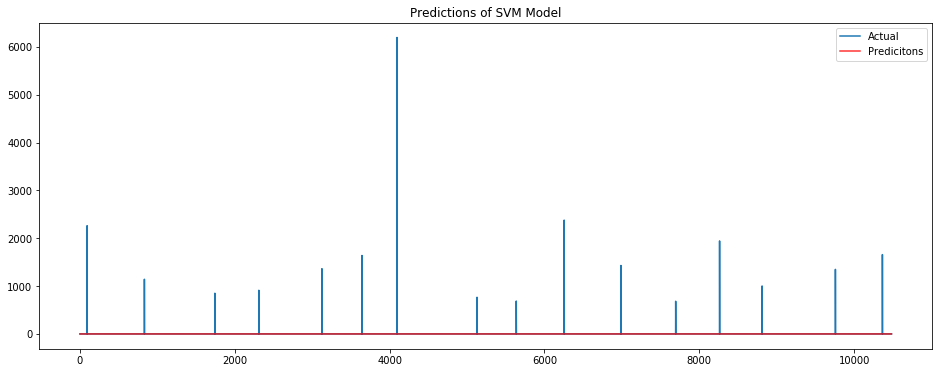

In [134]:
plt.figure(figsize=(16,6))
plt.plot(df.rtime_to_failure,'',label='Actual')
plt.plot(yhat,'r',label='Predicitons',alpha=0.8)
plt.title('Predictions of SVM Model')
plt.legend()
plt.show()

In [138]:
residuals = df.rtime_to_failure - yhat

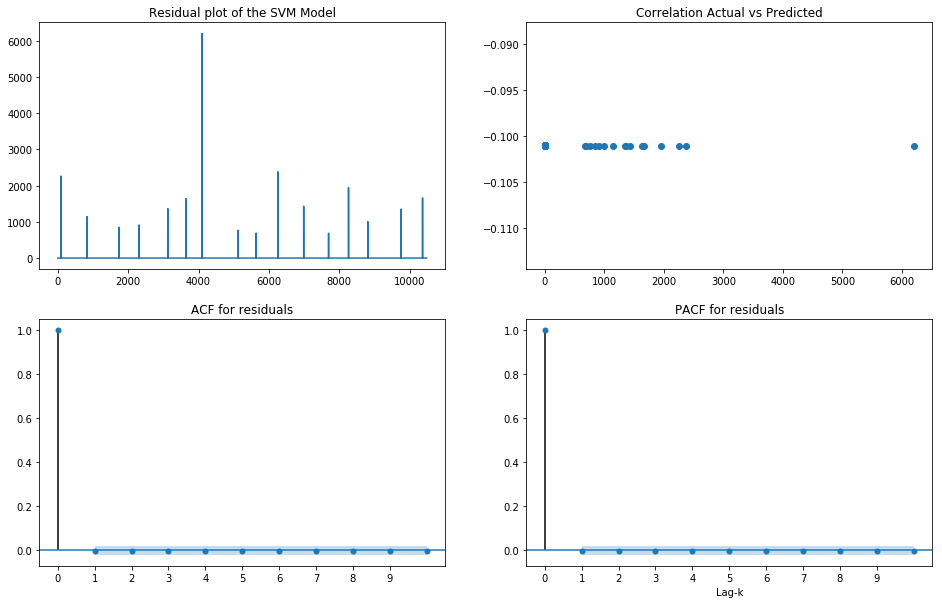

In [140]:
nlags = 10
fig = plt.figure(figsize=(16,10))
ax1 = plt.subplot(2, 2, 1)
ax1.plot(residuals)
plt.title("Residual plot of the SVM Model")
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(df.rtime_to_failure.values, yhat)
plt.title("Correlation Actual vs Predicted")
ax3 = plt.subplot(2, 2, 3)
fig = tsaplots.plot_acf(residuals, lags=nlags, ax=ax3,title='ACF for residuals')
plt.xticks(list(range(0,nlags)))
ax4 = plt.subplot(2, 2, 4)
fig = tsaplots.plot_pacf(residuals, lags=nlags, ax=ax4,title='PACF for residuals')
plt.xticks(list(range(0,nlags)))
plt.xlabel('Lag-k')
plt.show()